# Numerical Dynamics and @ThreeBodyBot &mdash; Kirk Long

In a dynamics class in my grad program we recently had the option to write our own homework, and I of course took the opportunity to write something up related to @ThreeBodyBot. I thought members of the community might be interested in a behind the scenes look at the math / numerics behind the bot, so I took what I did for the class and lightly modified it to turn it into a nice walkthrough, with fully worked out "solutions" to all the problems I wrote (although feel free to remove the solutions and generate your own if you want a "fun" challenge!). This notebook is in Julia just like the bot, but it should be easy to translate to other languages if you want, and you should be able to open the notebook as long as you have jupyter notebook installed &mdash; you just won't be able to run the code in the cells without a Julia installation. It's pretty easy to set up [should you choose to do so](https://datatofish.com/add-julia-to-jupyter/). The notebook is a little technical (apologies, too lazy to more than "lightly" edit) so might not be super accessible to everyone &mdash; especially if you don't have a physics/astronomy background &mdash; but even if you have no clue what's going on all the code should run so if you can figure out how to install Julia and run the notebook you can still play around with things and make some pretty pictures! One final note: the code here is more polished than the version of the code the bot currently uses &mdash; I originally wrote the bot when I was first learning Julia, so this was also a fun chance for me to revisit and clean it up a bit. The bot's code will be updated to use what I've done here eventually. 

## Exercise 1: The Generalized Three-Body Problem

We can analytically study two-body dynamics and limited three-body dynamics (i.e. where the third mass is negligible compared to the other two, or the separation of the third-body is large compared to the other two) &mdash; but what about systems that we can't approximate analytically? Even adding just a third, non-negligible mass becomes an ill-posed problem with not enough equations for our unknowns, and no exact analytic solution is possible &mdash; this is where computers come in! Although we cannot solve for the system analytically, we can always know the accelerations each body feels at any given instant (from Newton's laws) and we can thus approximate the true solution pretty well by taking small steps forward in time and re-calculating these accelerations at each step. 

We'll start with a simple, planar universe, where each body feels an acceleration in the x and y directions like:

$$\frac{\mathrm{d}^2\mathbf{x_i}}{\mathrm{d}t^2} = \sum_{j\neq i} -GM_{j}\frac{\mathbf{x_i - x_j}}{r_{ij}^3}$$
$$\frac{\mathrm{d}^2\mathbf{y_i}}{\mathrm{d}t^2} = \sum_{j\neq i} -GM_{j}\frac{\mathbf{y_i - y_j}}{r_{ij}^3}$$

Where r denotes the distance between two bodies.

a.) Second-order differential equations are more cumbersone to work with, so let's first transform these second-order differential equations into a set of first-order differential equations:

**solution to part a:** 
We make the substitutions $\mathbf{v_x} = \frac{\mathrm{d}\mathbf{x}}{\mathrm{d}t}$ and $\mathbf{v_y} = \frac{\mathrm{d}\mathbf{x}}{\mathrm{d}t}$, and this then gives us:

$$\frac{\mathrm{d}\mathbf{x_i}}{\mathrm{d}t} = \mathbf{v_{x_i}}$$
$$\frac{\mathrm{d}\mathbf{x_i}}{\mathrm{d}t} = \mathbf{v_{y_i}}$$
$$\frac{\mathrm{d}\mathbf{v_{x_i}}}{\mathrm{d}t} = \sum_{j\neq i} -GM_{i}\frac{\mathbf{x_i-x_j}}{r_{ij}^3}$$
$$\frac{\mathrm{d}\mathbf{v_{y_i}}}{\mathrm{d}t} = \sum_{j\neq i} -GM_{i}\frac{\mathbf{y_i-y_j}}{r_{ij}^3}$$

b.) We're now ready to integrate! Let's start by using 4th order Runge-Kutta &mdash; the Runge-Kutta family of integrators are a widely used extension of the simple Euler method you probably remember learning about in a calculus class. The algorithm goes like: 

```julia 
for i=1:nSteps
    k1 = Δt*fPrime(x,t)
    k2 = Δt*fPrime(x+k1/2,t+Δt/2)
    k3 = Δt*fPrime(x+k2/2,t+Δt/2)
    k4 = Δt*fPrime(x+k3,t+Δt)
    x += (k1+2*k2+2*k3+k4)/6
end
```

Where `fPrime` is the function to be integrated and in general can be both a function of position and time, `Δt` is the time step, `x` is the current position, `t` is the current time, `i` is the current step, and `nSteps` is the total number of integration steps to be taken.

Using the equations and algorithm above, create a function that can be your `fPrime` and test that you can reproduce the Earth's orbit (for simplicity you can fix the position of the Sun). *Hint:* it will be easiest if you start the Earth at one of the axes, such that all of its initial velocity is in x or y, and you can calculate this initial velocity assuming a circular orbit at a distance of 1 AU. Since your equations are independent at each time step, you can compute all of their updates in one loop. Run your simulation for several years (of simulation time) and verify that you can reproduce a circular orbit at 1 AU. 

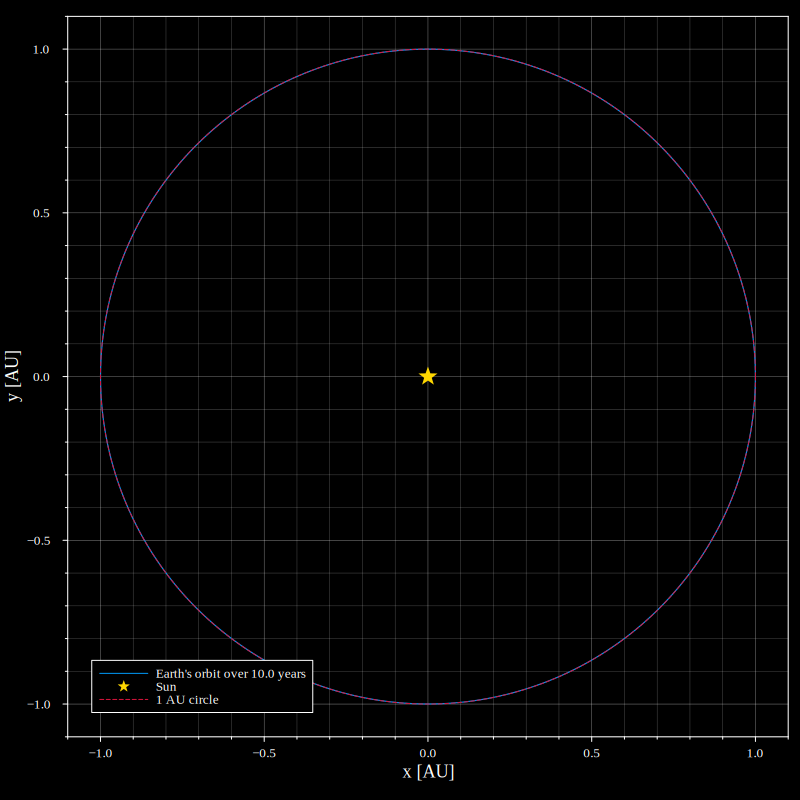

In [1]:
#solution to part b
const G = 6.67e-11; const Msun = 2e30; const AU = 1.5e11; const v0 = √(G*Msun/AU) #SI

function dR(r,v)
    dv = -G*Msun/(r[1]^2+r[2]^2)^(3/2) .* r #change in velocity is acceleration due to gravity * dt
    dr = v #change in posiiton is just velocity * dt
    return dr,dv
end

#initialize system
r = [-AU,0]
θ = atan(r[2],r[1])
v = [-v0*sin(θ),v0*cos(θ)]

t = range(0,stop=10,length=1001) #years
yearSec = 365*24*3600
Δt = (t[2]-t[1])*yearSec #s
x4Plot = zeros(length(t)); y4Plot = zeros(length(t))

#integrate using RK4!
for i=1:length(t)
    k1 = Δt .* dR(r,v) 
    k2 = Δt .* dR(r .+ k1[1]./2, v .+ k1[2]./2)
    k3 = Δt .* dR(r .+ k2[1]./2, v .+ k2[2]./2)
    k4 = Δt .* dR(r .+ k3[1], v .+ k3[2])
    r .+= (k1[1] .+ 2 .* k2[1] .+ 2 .* k3[1] .+ k4[1])./6
    v .+= (k1[2] .+ 2 .* k2[2] .+ 2 .* k3[2] .+ k4[2])./6
    x4Plot[i], y4Plot[i] = r[1], r[2]
end

#make plot!
using Plots,Plots.Measures
default(fontfamily="times",minorgrid=true,minorticks=true,tickdirection=:out,widen=false)
p=plot(x4Plot./AU,y4Plot./AU,label="Earth's orbit over $(t[end]) years",aspect_ratio=:equal,
    xlabel="x [AU]",ylabel="y [AU]",size=(800,800),xlims=(-1.1,1.1),ylims=(-1.1,1.1),
    background_color=:black,gridalpha=0.5,minorgridalpha=0.3,framestyle=:box)
p=scatter!([0.],[0.],label="Sun",color=:gold,marker=:star,markerstrokewidth=0,markersize=10)
r = ones(1001); θ = range(0,stop=2*π,length=1001)
p=plot!(r.*cos.(θ),r.*sin.(θ),color=:crimson,linestyle=:dash,label="1 AU circle")
png(p,"EarthSun.png") #save the picture
display(p)

Here's my version:

![EarthSunTest](EarthSun.png)

b.) How accurate is this solution over time? The integration routine given to you is an *explicit* scheme, which means there will always be some energy loss accrued at each time step. We can observe this behavior by watching the total energy over time. Calculate this energy loss over a year of Earth's orbit for a range of possible time steps. What do you notice? 

*Note*: a common alternative, energy-conserving scheme is the velocity Verlet method, which instead produces oscillatory behavior about the "true" energy. This makes it work well for stable systems at large distances, but it's not suitable for close encounters. "Real" codes use fancy combined methods that utilize both kinds of routines depending on the physical situation, and are accurate to 15th order!

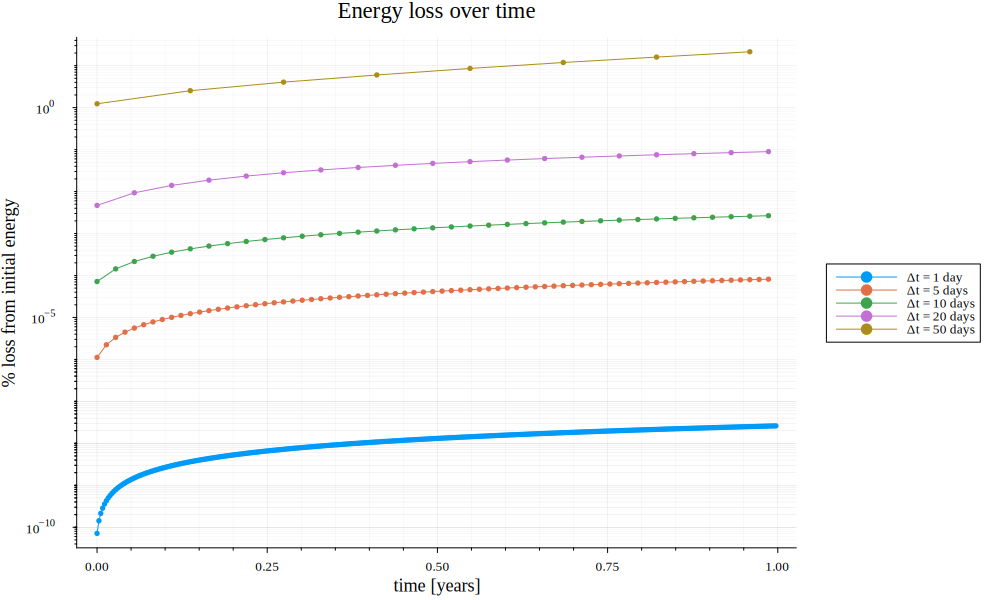

In [3]:
#solution to part b
function EarthYearEnergy(Δt)
    r = [0.,AU]
    v = [v0,0.]
    t = 0
    yearSec = 365*24*3600
    Δts = Δt*yearSec
    x4Plot = zeros(length(t)); y4Plot = zeros(length(t))
    i = 1; Me = 6e24; Msun = 2e30; energy = []; T = []
    initEnergy = -G*Me*Msun/AU + Me*v0^2/2
    while t<yearSec
        k1 = Δts .* dR(r,v) 
        k2 = Δts .* dR(r .+ k1[1]./2, v .+ k1[2]./2)
        k3 = Δts.* dR(r .+ k2[1]./2, v .+ k2[2]./2)
        k4 = Δts .* dR(r .+ k3[1], v .+ k3[2])
        r .+= (k1[1] .+ 2 .* k2[1] .+ 2 .* k3[1] .+ k4[1])./6
        v .+= (k1[2] .+ 2 .* k2[2] .+ 2 .* k3[2] .+ k4[2])./6
        R = √(r[1]^2 +r[2]^2); V² = v[1]^2+v[2]^2
        energyΔ = abs((initEnergy - (-G*Me*Msun/R + Me*V²/2))/initEnergy)*100
        push!(energy,energyΔ)
        push!(T,t)
        t += Δts; i += 1
    end
    return T./yearSec,energy
end

p=plot(EarthYearEnergy(1/365),label="Δt = 1 day",marker=:circle,markerstrokewidth=0,markersize=3)
p=plot!(EarthYearEnergy(5/365),label="Δt = 5 days",marker=:circle,markerstrokewidth=0,markersize=3)
p=plot!(EarthYearEnergy(10/365),label="Δt = 10 days",marker=:circle,markerstrokewidth=0,markersize=3)
p=plot!(EarthYearEnergy(20/365),label="Δt = 20 days",marker=:circle,markerstrokewidth=0,markersize=3)
p=plot!(EarthYearEnergy(50/365),label="Δt = 50 days",marker=:circle,markerstrokewidth=0,markersize=3)
p=plot!(title="Energy loss over time",ylabel="% loss from initial energy",xlabel="time [years]",size=(1000,600),yaxis=:log,widen=true,legend=:outerright,margins=3mm)
png(p,"EnergyLoss.png")
display(p)

Here's my version:

![EnergyLoss](EnergyLoss.png)

**Solution to b continued:** Clearly we can see that for time steps even as large as 20 days the total accumulated error over the year is relatively small, and we can maintain a high degree of accuracy for many many years with a time step of a day (for a total error of $10^{-7.5}$% over one year we would need to run the simulation for more than 30 million years to accumulate an error of just 1%). Determining what is an acceptable amount of error is important in setting the time step, and many of the fancier codes utilize adaptive time steps that further mitigate this (i.e. they detect when the change in energy passes a certain threshold and then re-calculate with a smaller time step to keep the total accumulated error at each macroscopic time step beneath said threshold). 

c.) Now that you've verified this method can produce sensible results, extend your work above to simulate the evolution of a three-body system. Verify your solution works by reproducing the pretty "figure-eight" solution with the following initial conditions (from Chencimer and Montgomery, 2000):

$$\mathbf{r_1}(0) = -\mathbf{r_3}(0) = (-0.97000436,0.24208753)$$
$$\mathbf{r_2}(0) = (0,0)$$
$$\mathbf{v_1}(0) = \mathbf{v_3}(0) = (0.4662036850, 0.4323657300)$$
$$\mathbf{v_2}(0) = (-0.933240737, -0.86473146)$$ 
$$m_1 = m_2 = m_3$$

The above initial conditions assume the gravitational constant is set to 1 &mdash; feel free to modify this if you prefer a more "physical" system, just make sure to also proportionally change the initial conditions. 

Tip: while not explicitly required, it may be nice to keep your code as general as possible as problem two will have you generalize to n-bodies.

Again plot the energy over time to make sure your solution is sensible. 

[ Info: Saved animation to /home/kirk/Documents/3Body/NumericsTutorial/tmp.gif


Plots.AnimatedGif("/home/kirk/Documents/3Body/NumericsTutorial/tmp.gif")
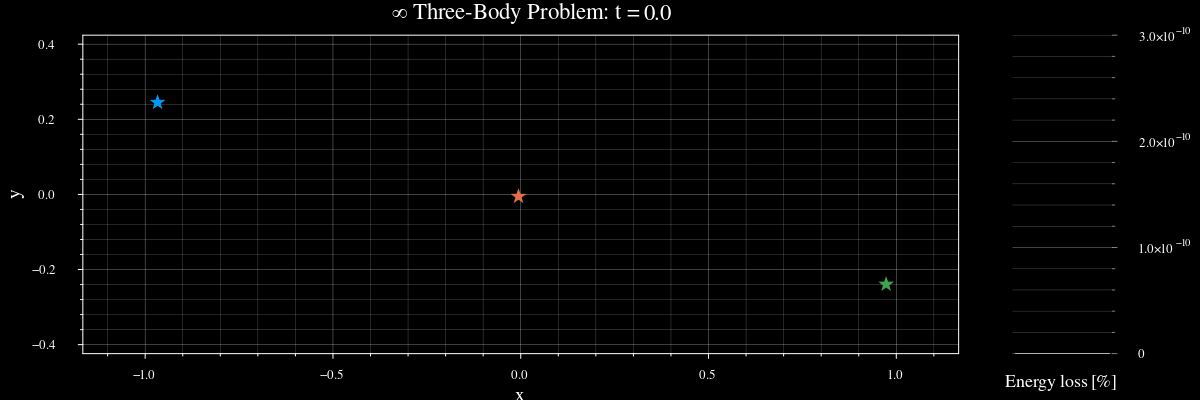

In [7]:
#solution to c
function Δr(coords,masses,nBodies,G) #this is a generalized version of what we had before for nBodies, different masses, and different values of G
    x,y,vx,vy = deepcopy(coords) #in Julia saying a = b just sets pointers by default, this creates a physical copy in memory
    Δ = deepcopy(coords)
    for n=1:nBodies
        xn = x[n]; yn = y[n] #assign them new variables here for computational efficiency, minimize calls to access memory
        Δvx = 0.; Δvy = 0.
        for i=1:nBodies #generalizing for later n-body problem
            if i!=n #only calculate if not self
                sep = sqrt((xn-x[i])^2+(yn-y[i])^2) #euclidean distance
                Δvx -= G*masses[i]*(xn - x[i])/sep^3 #change in velocity from each mass on mass n
                Δvy -= G*masses[i]*(yn - y[i])/sep^3
            end
        end
        Δ[3][n] = Δvx #change in velocity = a*t
        Δ[4][n] = Δvy
    end
    Δ[1] = vx #change in position = v*t
    Δ[2] = vy
    return Δ
end

function step!(coords,masses,Δt,nBodies=3,G=6.67408313131313e-11) #1 RK4 step for each body's coordinates, mutates coords
    k1 = Δt.*Δr(coords,masses,nBodies,G)
    k2 = Δt.*Δr(coords .+ k1./2,masses,nBodies,G)
    k3 = Δt.*Δr(coords .+ k2./2,masses,nBodies,G)
    k4 = Δt.*Δr(coords .+ k3,masses,nBodies,G)
    coords .+= (k1 .+ 2.0.*k2 .+ 2.0.*k3 .+ k4)./6
    return coords #return changes in position and velocity
end

#Initial conditions setup -- you can modify these to make whatever three-body animations you want!
M = [1,1,1] #m1=m2=m3
x = [-0.97000436,0.,0.97000436] #x1 = -x3, x2 = 0
y = [0.24208753,0.,-0.24208753] #y1 = -y3, y2 = 0
vx = [0.4662036850,-0.933240737,0.4662036850] #v1x = v3x
vy = [0.4323657300,-0.86473146,0.4323657300] #v1y = v3y
Ei = -1/√((2*0.97000436)^2+(2*0.24208753)^2) - 2/√(0.97000436^2+0.24208753^2) + 0.5*sum(vx.^2 .+ vy.^2)#r23 = r12

coords = [x,y,vx,vy] #array of initial conditions 
time = range(0,stop=6.3259,length=1001); Δt = time[2]-time[1] #the periodicity of this system is ~6.3259 in these natural units

X = zeros(3,length(time)); Y = zeros(3,length(time)); VX = zeros(3,length(time)); VY = zeros(3,length(time)) #initialize tracking arrays
for i = 1:length(time)
    coords = step!(coords,M,Δt,3,1) #evolve the system at each time step
    X[:,i] = coords[1]; Y[:,i] = coords[2] #keep track of position at each time step
    VX[:,i] = coords[3]; VY[:,i] = coords[4]
end

using Plots.Measures
#make a simple animation of our results
@gif for i=1:length(time)
    p1=plot(size=(1000,400),widen=true,aspect_ratio=:equal,xlims=(-1.1,1.1),ylims=(-0.4,0.4),xlabel="x",ylabel="y",title="∞ Three-Body Problem: t = ",
    background_color=:black,gridalpha=0.5,minorgridalpha=0.3,framestyle=:box,margins=4mm,titlefonthalign=:left,titlefontsize=14,guidefontsize=10,labelfontsize=12)
    #p1=annotate!(0.6,1.,Plots.text("$(round(time[i],sigdigits=3))","white",14))
    p1=annotate!([(0.33,0.485,("$(round(time[i],sigdigits=3))",14,:white,:left))]) #because it really annoys me when the title bounces around as the number changes
    p1=plot!(X[1,1:i],Y[1,1:i],label="",lw=2,linealpha=max.((1:i) .+ 100 .- i,20)/100)
    p1=plot!(X[2,1:i],Y[2,1:i],label="",lw=2,linealpha=max.((1:i) .+ 100 .- i,20)/100)
    p1=plot!(X[3,1:i],Y[3,1:i],label="",lw=2,linealpha=max.((1:i) .+ 100 .- i,20)/100)
    p1=scatter!([X[1,i]],[Y[1,i]],label="",marker=:star,c=1,markerstrokewidth=0,markersize=8)
    p1=scatter!([X[2,i]],[Y[2,i]],label="",marker=:star,c=2,markerstrokewidth=0,markersize=8)
    p1=scatter!([X[3,i]],[Y[3,i]],label="",marker=:star,c=3,markerstrokewidth=0,markersize=8)
    r12 = √((X[1,i]-X[2,i])^2+(Y[1,i]-Y[2,i])^2); r13 = √((X[1,i]-X[3,i])^2+(Y[1,i]-Y[3,i])^2); r23 = √((X[3,i]-X[2,i])^2+(Y[3,i]-Y[2,i])^2)
    U = -1/r12 - 1/r13 - 1/r23 #G = m = 1
    K = 0.5*sum(VX[:,i].^2 .+ VY[:,i].^2) #m=1
    ΔE = abs((U+K-Ei)/Ei)
    p2 = bar([ΔE],ylims=(0,3e-10),label="",xticks=false,xlabel="Energy loss [%]",ylabel="",grid=true,minorgrid=true,minorgridalpha=0.3,gridalpha=0.5,
        background_color=:black,framestyle=:grid,margins=3mm,c=:crimson,ymirror=true,widen=false,tickdirection=:out,yticks=true,yminorticks=true)
    #p2 = hline!([0.,1e-10,2e-10,3e-10],c=:white,label="")
    plot(p1,p2,layout=@layout([A B{0.1w}]),size=(1200,400))
end every 10

Again here's my resulting animation:

![Figure 8 solution](figure8.gif)

d.) This solution is only locally stable. Modify your code to perturb the initial position of the second body and observe what happens. Add conditions to your code to detect when two objects have "collided" (you can consider multiple ways to handle this, but one suggestion is to consider a "sphere" based on the timestep and current velocities of each body, and if their spheres overlap a collision may have happened) and when one has become unbound from the system (take the condition where the closest separation goes to 10x the farthest initial separation to quantify this), then run 100,000 trials with random perturbations in the initial conditions of the second body, recording the outcomes as either "stable", a "collision", or an "escape". Take the system to be "stable" if it survives 100x the length of the original period. Illustrate how the long the system lasts as a function of initial position however you see fit.

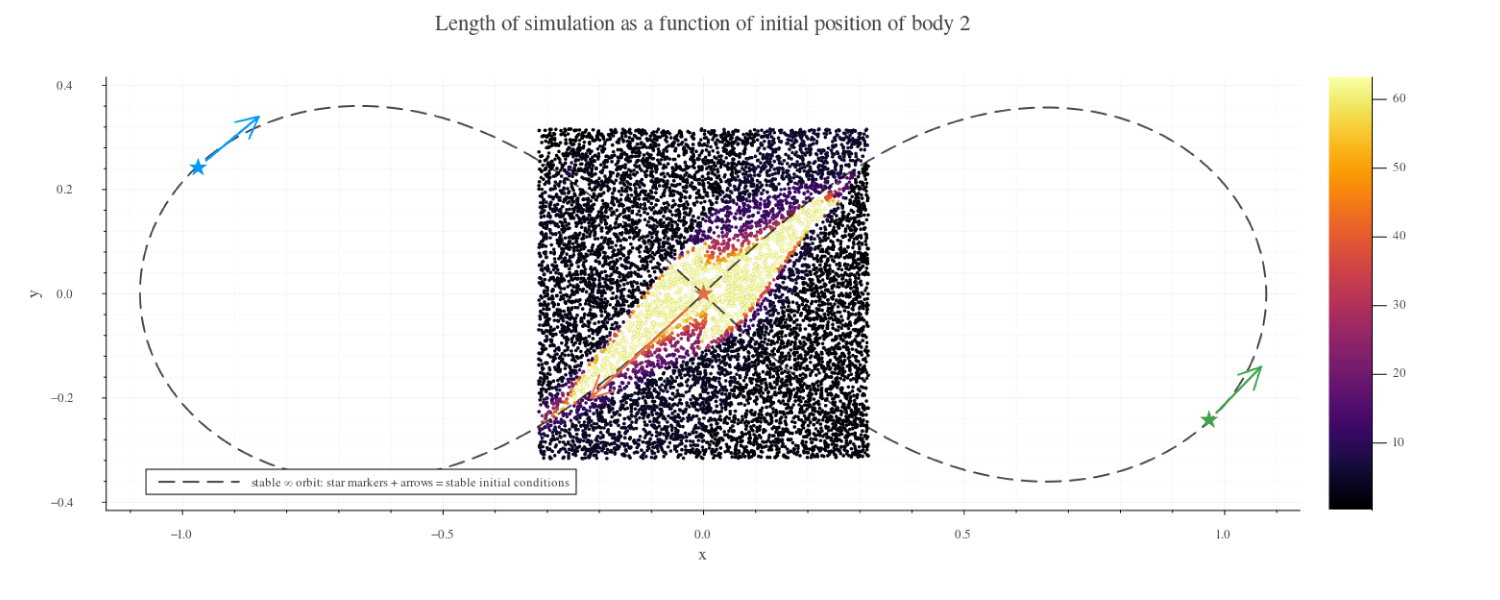

In [9]:
#solution to d
using Distributions
function detectCollisionsEscape(coords,Δt,maxSep) #this tells us if two bodies have "collided" or one has "escaped"
    x,y,vx,vy = coords
    V = sqrt.(vx.^2 .+ vy.^2)
    R = V.*Δt
    collision = false; collisionInds = nothing; escape = false; escapeInd = nothing
    for n=1:length(x)
        rn = R[n]; xn = x[n]; yn = y[n]
        for i=1:length(x) 
            if i!=n #don't check if we collided with ourselves!
                minSep = rn+R[i]
                sep = √((xn-x[i])^2+(yn-y[i])^2)
                if sep<minSep #collision!
                    collision = true
                    collisionInds = n,i
                    return collision,collisionInds,escape,escapeInd
                elseif sep>maxSep #escape!
                    escape = true
                    escapeInd = n
                    return collision,collisionInds,escape,escapeInd
                end
            end
        end
    end
    return collision,collisionInds,escape,escapeInd
end

function perturbTest(δMax=0.1) #this function tests how long system lasts for a random small perturbation of the initial position of body 2
    #Initial conditions setup
    M = [1,1,1] #m1=m2=m3
    x = [-0.97000436,0.0+rand(Uniform(-1.,1.))*√δMax,0.97000436] #x1 = -x3, x2 = 0 + perturbation
    y = [0.24208753,0.0+rand(Uniform(-1.,1.))*√δMax,-0.24208753] #y1 = -y3, y2 = 0 + perturbation
    vx = [0.4662036850,-0.933240737,0.4662036850] #v1x = v3x
    vy = [0.4323657300,-0.86473146,0.4323657300] #v1y = v3y
    
    coords = [x,y,vx,vy] #array of initial conditions 
    initCoords = deepcopy([x[2],y[2]]) #keep track for output later
    time = range(0,stop=6.3259*10,length=1001); Δt = time[2]-time[1] #the periodicity of this system is ~6.3259 in these units
    maxSep = 10*√((2*0.97000436)^2+(2*0.24208753)^2) #biggest distance apart is at start between bodies 1-3
    collision,collisionInds,escape,escapeInd = false,nothing,false,nothing
    for i = 1:length(time)
        coords = step!(coords,M,Δt,3,1) #update coords at each time step
        collision,collisionInds,escape,escapeInd = detectCollisionsEscape(coords,Δt,maxSep) #has something collided or escaped?
        if collision == true || escape == true #if something escapes or collides the simulation has ended, return values
            return collision,collisionInds,escape,escapeInd,initCoords,time[i]
        end
    end
    return collision,collisionInds,escape,escapeInd,initCoords,time[end]
end

using DataFrames,Printf
N = 10000 #number of random trials, make this number higher to get a prettier / more accurate plot (but it also takes a lot longer to run...)
Names = [:collision,:escape,:T,:x,:y,:r] #names for columns 
Types = [Bool,Bool,Float64,Float64,Float64,Float64] #types for columns
df = DataFrame(Names .=> [Vector{type}(undef,N) for type in Types]) #make empty df with column names and types 

for i=1:N
    if i%(N/1000) == 0; print("$(@sprintf("%.2f",i/N*100)) % complete\r"); end#output percent tracker
    collision,collisionInds,escape,escapeInd,initCoords,T = perturbTest() #perform a random test
    df.collision[i] = collision; df.escape[i] = escape; df.T[i] = T; df.x[i] = initCoords[1]; df.y[i] = initCoords[2]; df.r[i] = √(initCoords[1]^2+initCoords[2]^2) #put results in df
end

#visualize results!
p = scatter(df.x,df.y,marker_z=df.T,markerstrokewidth=0,markersize=2,label="",margins=5mm)
p = plot!(X[2,:],Y[2,:],linestyle=:dash,c=:black,lw=2,linealpha=0.7,label="stable ∞ orbit: star markers + arrows = stable initial conditions")
p = scatter!([-0.97000436,0.0,0.97000436],[0.24208753,0.0,-0.24208753],label="",marker=:star,markersize=10,markerstrokewidth=0,c=[1,2,3])
p = quiver!(X[1,5:100:50],Y[1,5:100:50],quiver=(VX[1,5:100:50]./5,VY[1,5:100:50]./5),label="",lw=2,c=1) #add arrows
p = quiver!(X[3,5:100:50],Y[3,5:100:50],quiver=(VX[3,5:100:50]./5,VY[3,5:100:50]./5),label="",lw=2,c=3) 
p = quiver!(X[2,5:30:30],Y[2,5:30:30],quiver=(VX[2,5:30:30]./5,VY[2,5:30:30]./5),label="",lw=2,c=2)
p = plot!(size=(1500,600),aspect_ratio=:equal,title="Length of simulation as a function of initial position of body 2",xlabel="x",ylabel="y",widen=true)
png(p,"chaos.png"); closeall() #this one slows things down and takes forever to display, so this "hack" saves as png, closes plots, then opens the picture as a new "plot"
using Images
img = load("chaos.png")
plot(img,size=(size(img)[2],size(img)[1]),axis=false,frame=false,ticks=false)
#to do a real heat map need to go through every possible y at each x on a grid, but this random approach is more fun I think and illustrates the same thing 

Here's what one run I did wih 100,000 random points produced!

![stability plot](chaos.png)

I chose to make a scatter plot as opposed to a heatmap as I like the random sampling of the space, but could also generate a more rigorous 2D meshgrid and make contours to explore that way. Either way, this plot is super interesting and you can see how small perturbations are still "stable" for the system, and that the contours of "stability" are symmetric! Note that the little white dots in the figure are not long lasting solutions but instead the background poking through in an area my random sampler didn't cover.

## Exercise 2: N-body dynamics

Extend your code from the previous part to simulate n-bodies, with collisions handled perfectly inelastically. Make a toy model of an early solar system in 2D, assuming a central star of 1 solar mass, ~1,000 particles of negligible mass (take them to be 1/10000 times a solar mass) and simulate its evolution for 1 year, assuming roughly Keplerian scaling for an initial "cloud" of planetesimals randomly distributed in a 2 AU circle around the central star. 

In [10]:
#solution to exercise 2
using Distributions
function nBodyStep!(coords,masses,Δt,maxSep,nBodies,G=6.67408313131313e-11) #similar to our step function before, but keeping track of collisions
    coords = step!(coords,masses,Δt,nBodies,G) #update the positions as we did before
    collision,collisionInds,escape,escapeInd = detectCollisionsEscape(coords,Δt,maxSep) #detect collisions/escapes
    if collision == true #do inelastic collision and delete extra body (2 -> 1)
        i1,i2 = collisionInds
        x1,x2 = coords[1][i1],coords[1][i2]
        y1,y2 = coords[2][i1],coords[2][i2]
        vx1,vx2 = coords[3][i1],coords[3][i2]
        vy1,vy2 = coords[4][i1],coords[4][i2]
        px1,px2 = masses[i1]*vx1,masses[i2]*vx2
        py1,py2 = masses[i1]*vy1,masses[i2]*vy2
        px = px1+px2
        py = py1+py2
        newM = masses[i1]+masses[i2]
        vfx = px/newM
        vfy = py/newM
        coords[1][i1] = (x1*masses[i1]+x2*masses[i2])/(masses[i1]+masses[i2]) #center of mass
        coords[2][i1] = (y1*masses[i1]+y2*masses[i2])/(masses[i1]+masses[i2])
        coords[3][i1] = vfx
        coords[4][i1] = vfy
        deleteat!(coords[1],i2); deleteat!(coords[2],i2); deleteat!(coords[3],i2); deleteat!(coords[4],i2)
        masses[i1] = newM
        deleteat!(masses,i2)
        nBodies-=1
    end
    #could also implement condition for escape where we stop calculating forces but I'm too lazy for now
    return coords,masses,nBodies,collision,collisionInds,escape,escapeInd
end

function genNBodyResults(nBodies,tStop,nTPts,nBodiesStop=10,G=6.67408313131313e-11)
    coords = [zeros(nBodies),zeros(nBodies),zeros(nBodies),zeros(nBodies)] 
    Mstar = 2e30; Mp = Mstar/1e4
    for i=1:nBodies #initialize coordinates on ~Keplerian orbits
        accept = false; r = nothing
        while accept == false #prevent a particle from spawning within 0.2 AU too close to "star"
            r = rand()*2*1.5e11 #say radius of 2 AU
            if r/1.5e11 > 0.2
                accept = true
            end
        end
        θ = rand(Uniform(0,2*π))
        x = r*cos(θ); y = r*sin(θ)
        v = √(G*Mstar/r)
        v += v/1000*rand(Uniform(-1,1)) #perturb the velocities ever so slightly 
        θ = atan(y,x)
        coords[1][i] = x; coords[2][i] = y
        coords[3][i] = -v*sin(θ); coords[4][i] = v*cos(θ)
    end

    masses = Mp.*ones(nBodies) #initialize masses
    masses[1] = Mstar #make index one special as the central star
    coords[1][1] = 0.; coords[2][1] = 0.; coords[3][1] = 0.; coords[4][1] = 0. #initialize central star at origin with no velocity
    yearSec = 365*24*3600
    time = range(0,stop=tStop,length=nTPts).*yearSec #years -> s
    t = time[1]; Δt = time[2]-time[1]; tInd = 1
    coordsRecord = [deepcopy(coords)]; massRecord = [deepcopy(masses)] #initialize records with initial conditions
    while tInd<length(time) && nBodies > nBodiesStop #keep going until we get to maximum time or most things have collided
        coords,masses,nBodies,collision,collisionInds,escape,escapeInd = nBodyStep!(coords,masses,Δt,10*1.5e11,nBodies,G) #update 
        push!(coordsRecord,deepcopy(coords)); push!(massRecord,deepcopy(masses)) #add to records
        tInd += 1
        t = time[tInd]
        print("currently at t = $(@sprintf("%.2f",t/yearSec)) years\r")
    end
    println("final time = $(time[tInd]/yearSec) years with $nBodies bodies remaining")
    return coordsRecord,massRecord,time[1:tInd]
end

coordsRecord,massRecord,t = genNBodyResults(1000,1,1001);  

final time = 1.0 years with 948 bodies remaining


[ Info: Saved animation to /home/kirk/Documents/3Body/NumericsTutorial/tmp.gif


Plots.AnimatedGif("/home/kirk/Documents/3Body/NumericsTutorial/tmp.gif")
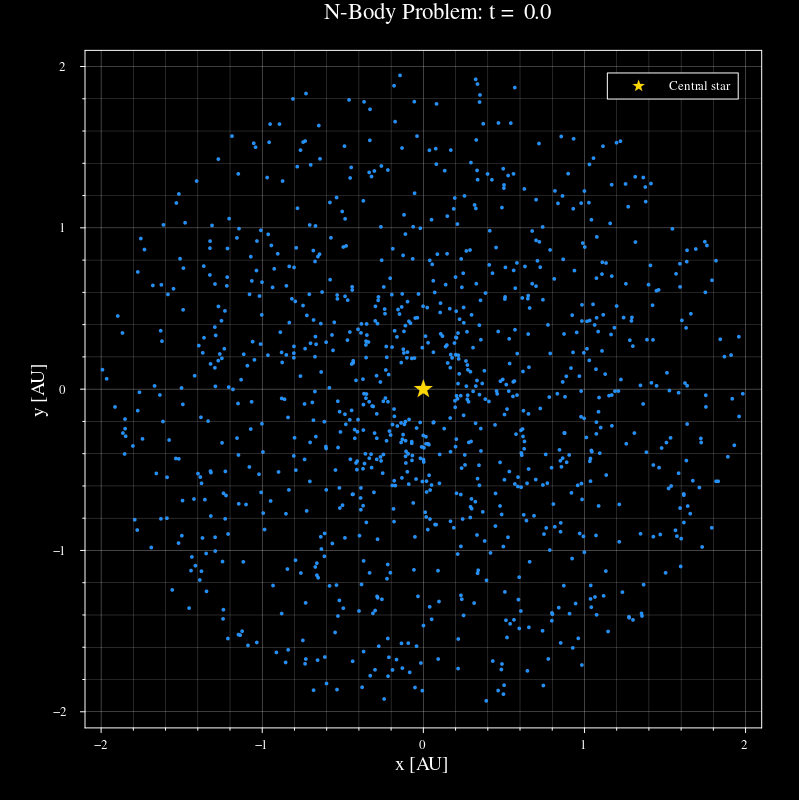

In [17]:
#visualize our solution (takes a while)
@gif for i=1:length(t)
    print("$(@sprintf("%.2f",i/length(t)*100)) % complete\r")
    p1=plot(size=(800,800),widen=false,aspect_ratio=:equal,xlims=(-2.1,2.1),ylims=(-2.1,2.1),xlabel="x [AU]",ylabel="y [AU]",title="N-Body Problem: t = ",legend=:topright,
    background_color=:black,gridalpha=0.5,minorgridalpha=0.3,framestyle=:box,margins=4mm,titlefonthalign=:left,titlefontsize=14,guidefontsize=10,labelfontsize=12)
    p1=annotate!([(0.63,2.343,("$(round(t[i]/yearSec,sigdigits=3))",14,:white,:left))]) #because it really annoys me when the title bounces around as the number changes
    coords = coordsRecord[i]
    for n=1:length(coords[1])
        label = n==1 ? "Central star" : ""; ms = n==1 ? 10 : 2; c = n==1 ? :gold : :dodgerblue; marker = n==1 ? :star : :dot
        p1=scatter!([coords[1][n]/1.5e11],[coords[2][n]/1.5e11],label=label,marker=marker,c=c,markerstrokewidth=0,markersize=ms)
    end
end every 10

And here are the results of one such run! Pretty fun I think and relatively simple to code up. :) 

![nbody sim](nbody.gif)

Natural extensions of this would be to add a z coordinate, implement an adaptive time step, improve the accuracy of the integrator itself (i.e. combine with symplectic integrator and add more RK steps to get to higher order accuracy), and parallelize the n-body acceleration calculations. This is mostly just a toy code, but I hope it's helpful to see the basics of how these sorts of things are done in real life, and I hope it's a nice behind the scenes look at the bot itself. Enjoy!